In [2]:
from fastai.structured import *
from fastai.column_data import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import pickle

In [3]:
# lets load the data
df = pd.read_csv('course_ratings.csv')

In [4]:
#lets remove high rating rows
joined = df.drop(df[df['rating'] > 5].index)

In [5]:
# lets define catigorical vars
cat_vars = ['user','course','category','job','institution','state']
#coninuous vars
cont_vars = ['rating']

# df length
n = len(df)

# test percentage
testp = n*.2

#lets update features, categoricial should be category and continuous should be float32
for v in cat_vars: 
    joined[v] = joined[v].astype('category').cat.as_ordered()
    
for v in cont_vars:
    joined[v] = joined[v].fillna(0).astype('float32')

In [6]:
# we have to convert all category variables into contiguous ones and save the look up table
lookup_table = {}
for c in cat_vars:
    uq = joined[c].unique()
    col2idx =  {o:i for i,o in enumerate(sorted(uq))}
    lookup_table[c] = col2idx
    joined[c] = joined[c].apply(lambda x: col2idx[x])

In [7]:
#lets save the mapper for later use
with open('models/data/lookup_table', 'wb') as fp:
    pickle.dump(lookup_table, fp)

In [8]:
#lets check lookup table
with open ('models/data/lookup_table', 'rb') as fp:
    lut_load = pickle.load(fp)

#lut_load

In [9]:
# create a test/train set split
joined, joined_test = train_test_split(joined, test_size=0.25)
df = joined.drop('rating', axis=1)
y = joined['rating']
df_test = joined_test.drop('rating', axis=1)

# create a validation set of ids
train_ratio = 0.75
train_size = int(len(df) * train_ratio)
val_idx = list(range(train_size, len(df)))

with open('models/data/val_idx', 'wb') as fp:
    pickle.dump(val_idx, fp)
    
with open('models/data/ratings', 'wb') as fp:
    pickle.dump(y, fp)

In [10]:
#final df , everything is numeric and continguous
with open('models/data/final_df', 'wb') as fp:
    pickle.dump(df, fp)

In [11]:
df.head(10)

,user,course,category,job,institution,state
170932,21502,84,7,44,0,30
120090,11867,171,7,6,9,30
166358,45579,170,8,6,14,49
82925,31960,201,7,6,9,45
19778,39500,175,7,39,9,30
145662,19410,175,7,44,9,39
126946,41576,189,0,28,0,45
56346,39737,172,7,6,11,44
104905,5812,3,1,42,0,16
47418,17557,203,7,6,0,57


In [12]:
#lets build the initial model
md = ColumnarModelData.from_data_frame("models/", val_idx, df, y.astype(np.float32), cat_flds=cat_vars, bs=128, test_df=df_test)

In [13]:
#build embedding matrix, matrices should be 1 bigger then the the number of categorical options to leave room for unknown
cat_sz = [(c, len(joined[c].cat.categories)+1) for c in cat_vars]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
with open('models/data/emb_sizes', 'wb') as fp:
    pickle.dump(emb_szs, fp)

In [14]:
#build the learner, 
# .04 dropout on the embedding matrix
# 1000 and 500 nodes on 2 different layers
# .001 and .01 dropouts
# specifying the range of y (rating) to be 0-5
m = md.get_learner(emb_szs,0 ,0.04, 1, [1000,500], [0.001,0.01],y_range=(0,5))

In [15]:
m.summary()

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 50]),
                           ('trainable', True),
                           ('nb_params', 2605900)])),
             ('Embedding-2',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 50]),
                           ('trainable', True),
                           ('nb_params', 11000)])),
             ('Embedding-3',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 8]),
                           ('trainable', True),
                           ('nb_params', 120)])),
             ('Embedding-4',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 23]),
                           ('trainable', True),
                           ('nb_params', 1058)])),
             ('Embedding-5',
              OrderedDict([('input_sh

In [16]:
#lets find a learning rate
m.lr_find()

 78%|███████▊  | 601/771 [00:19<00:05, 30.29it/s, loss=1.22] 

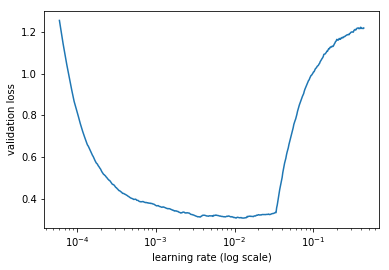

In [17]:
m.sched.plot(100)

In [18]:
lr = 1e-3

In [19]:
# Local
m.fit(lr, 2, cycle_len=2)

epoch      trn_loss   val_loss                                
    0      0.229473   0.22886   
    1      0.151192   0.2234                                  
    2      0.171232   0.219819                                
    3      0.114347   0.220079                                


[array([0.22008])]

In [20]:
# GPU
# lets fit the model, 50 epochs with restarts
#m.fit(lr, 50, cycle_len=5)

In [21]:
m.save('mdl')

In [22]:
m.load('mdl')

In [23]:
x,y=m.predict_with_targs()

In [24]:
pred_test=m.predict(is_test=True)

In [25]:
joined_test['rating_pred'] = pred_test

In [26]:
joined_test[['rating','rating_pred']].head(10)

,rating,rating_pred
22110,3.12,3.703446
72717,4.85,4.603347
116743,2.82,4.005052
93029,3.96,3.976959
121682,4.73,4.717495
154685,4.14,3.652032
33540,4.68,4.597418
73286,3.73,4.125097
107203,4.38,4.364199
49544,4.73,4.614361


In [27]:
rms = sqrt(mean_squared_error(joined_test['rating'], joined_test['rating_pred']))

In [33]:
# we achieved a root mean squared error of .46
rms

0.46578565104701386

In [29]:
test_record = df_test.iloc[0]

In [30]:
joined_test.iloc[0]

user             28637
course              64
category             7
rating            3.12
job                  6
institution          0
state               51
rating_pred    3.70345
Name: 22110, dtype: object

In [39]:
cat = test_record[cat_vars].values.astype(np.int64)[None]
contin = test_record.drop(cat_vars).values.astype(np.float32)[None]

#Prediction
model = m.model
model.eval()
prediction = to_np(model(V(cat),[]))

In [40]:
prediction[0][0]

3.7034464

In [ ]:
#model is ready, need to create simple api

In [43]:
cat

array([[28637,    64,     7,     6,     0,    51]])

In [45]:
V(cat)

Variable containing:
 28637     64      7      6      0     51
[torch.LongTensor of size 1x6]

In [50]:
x = V([[[2,3,4,5]]])

In [51]:
x

[Variable containing:
  2  3  4  5
 [torch.LongTensor of size 1x4]]